[0, 1, 2, 3]
use time: 68.66000008583069


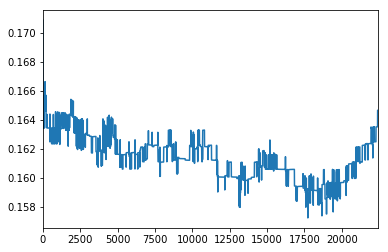

In [6]:
# encoding:utf-8
# 产生核对的数据
import datetime
import pymongo
import time
from math import log,sqrt,exp

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

#并行计算
import ipyparallel as ipp

#多处理
import multiprocessing as mp

#多线程
import numexpr as ne

#动态编译
import numba as nb
#静态编译
#############

c = ipp.Client()

print(c.ids)
    
def bsm_call(S,K,T,r,sigma):
    #S=float(S)
    d1=(log(S/K)+0.5*sigma**2*T)/(sigma*sqrt(T))
    d2=(log(S/K)-0.5*sigma**2*T)/(sigma*sqrt(T))
    value=(S*stats.norm.cdf(d1,0.0,1.0)-K*exp(-r*T)*stats.norm.cdf(d2,0.0,1.0))
    return value


def bsm_put(S,K,T,r,sigma):
    #S=float(S)
    d1=(log(S/K)+0.5*sigma**2*T)/(sigma*sqrt(T))
    d2=(log(S/K)-0.5*sigma**2*T)/(sigma*sqrt(T))
    value=(S*(stats.norm.cdf(d1,0.0,1.0)-1)-K*exp(-r*T)*(stats.norm.cdf(d2,0.0,1.0)-1))
    return value


def bsm_vega(S,K,T,r,sigma):
    #S=float(S)
    d1=(log(S/K)+0.5*sigma**2*T)/(sigma*sqrt(T))
    vega=S*stats.norm.cdf(d1,0.0,1.0)*sqrt(T)
    return vega


def bsm_call_imp_vol(S,K,T,r,C,sigma_est,it=200,control=0.01):
    i=0    
    while i<=it:
        sigma_est-=((bsm_call(S,K,T,r,sigma_est)-C)/bsm_vega(S,K,T,r,sigma_est)/100)
        if abs(bsm_call(S,K,T,r,sigma_est)-C)<control:
            return sigma_est
        else:
            i+=1
    return sigma_est


def bsm_put_imp_vol(S,K,T,r,P,sigma_est,it=200,control=0.01):
    i=0    
    while i<=it:
        sigma_est-=((bsm_put(S,K,T,r,sigma_est)-P)/bsm_vega(S,K,T,r,sigma_est)/100)
        if abs(bsm_put(S,K,T,r,sigma_est)-P)<control:
            return sigma_est
        else:
            i+=1
    return sigma_est

def calculate_vol(row):
    vol = bsm_call_imp_vol(S=row['askPrice1'], K=strike_price, T=0.2, r=0.03, C=row['askPrice1_c'], sigma_est=0.2)
    return {'datatime':row['datetime'], 'volatility': vol}

#创建服务器
default_client = pymongo.MongoClient('localhost', 27017)
#选择数据库
space_db = default_client['parity_space']
datetime1 = datetime.datetime(2017, 6, 7, 9, 0, 0)
datetime2 = datetime.datetime(2017, 6, 7, 15, 0, 0)
# projection是list形式
space_query = {
    'datetime':{'$gt': datetime1, '$lt':datetime2},
    'askPrice1':{'$gt': 0},
    'askPrice1_c':{'$gt': 0},
    'askPrice1_p':{'$gt': 0},
    'bidPrice1':{'$gt': 0},
    'bidPrice1_c':{'$gt': 0},
    'bidPrice1_p':{'$gt': 0},
    
}
start_time = time.time()
strike_price = 2700
#选择collection和document
db_name = 'Paritym1709' + str(strike_price) + 'Strategy'
docs = space_db[db_name].find(space_query).sort([('datetime', pymongo.ASCENDING)])

#多处理：失败
#pool = mp.Pool(processes=10)
#vol_list = pool.map(calculate_vol, list(docs))
#异步集群：语法错误
#vol_list = [c[:].apply_sync(calculate_vol, doc) for doc in docs]

last_vol = 0.2
vol_list = []
for row in docs:
    vol = bsm_call_imp_vol(S=row['askPrice1'], K=strike_price, T=0.1666, r=0.02, C=row['askPrice1_c'], sigma_est=last_vol)
    last_vol = vol
    vol_list.append({'datatime':row['datetime'], 'volatility': vol})

#vol_list = [calculate_vol(x) for x in docs]
#保存隐含波动率结果的df
vol_dataframe = pd.DataFrame(vol_list)

vol_dataframe.volatility.plot()
end_time = time.time()
print("use time: %r" % (end_time-start_time))
plt.show()